# How to Read STELLA models with TARDIS

In [15]:
from pathlib import Path
import os
home = str(Path.home())

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import yaml
from scipy import interpolate


from tardis.io.model import read_stella_model
from tardis.util.base import is_valid_nuclide_or_elem

from astropy import units as u


# STELLA_model_folder_name = "17eaw_pt8foe/NICKEL_0.048"
STELLA_model_folder_name = "6.4_stripped_1foe_0.03Ni"

STELLA_model_folder = f"{home}/Software/IIp_ddmc/{STELLA_model_folder_name}"
os.makedirs(f"{STELLA_model_folder}/tardis_configs", exist_ok=True)

INTERPOLATE_MASS_FRACTIONS = True

# Pick a model that is homologous expanding first 

day 00.1 Warning: the velocity is NOT monotonically increasing
day 00.2 Warning: the velocity is NOT monotonically increasing
day 00.3 Yay!!!
day 00.4 Yay!!!
day 00.5 Warning: the velocity is NOT monotonically increasing
day 00.6 Warning: the velocity is NOT monotonically increasing
day 00.7 Warning: the velocity is NOT monotonically increasing
day 00.8 Warning: the velocity is NOT monotonically increasing
day 00.9 Warning: the velocity is NOT monotonically increasing
day 01 Warning: the velocity is NOT monotonically increasing
day 02 Warning: the velocity is NOT monotonically increasing
day 03 Warning: the velocity is NOT monotonically increasing
day 04 Yay!!!
day 05 Warning: the velocity is NOT monotonically increasing
day 10 Warning: the velocity is NOT monotonically increasing
day 20 Warning: the velocity is NOT monotonically increasing
day 30 Warning: the velocity is NOT monotonically increasing
day 40 Warning: the velocity is NOT monotonically increasing
day 50 Warning: the veloc

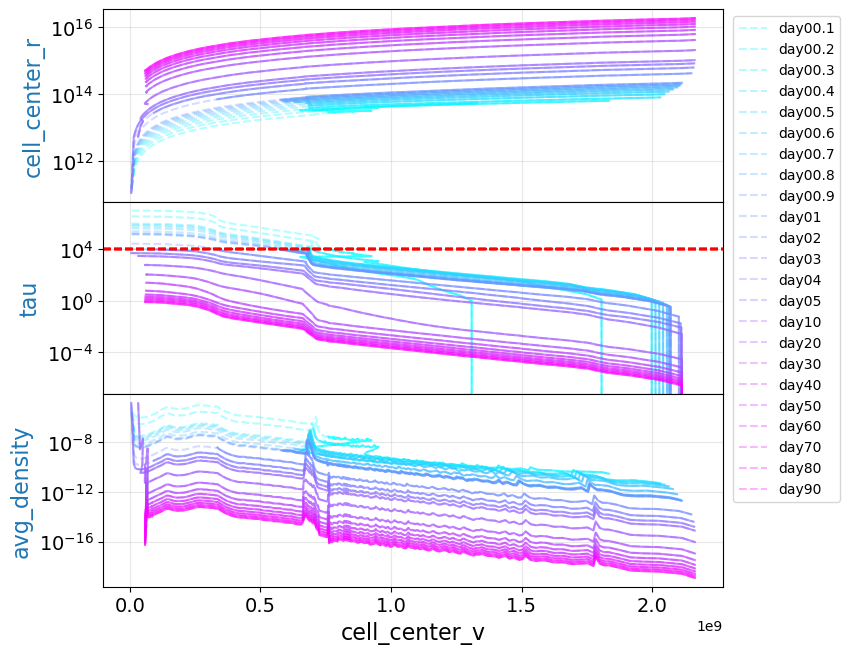

In [2]:
## check homologous expansion
x_col = "cell_center_v"
y_col_s = ["cell_center_r","tau","avg_density"]
tau_upper_limit = 1e4

days_str = ["00.1","00.2","00.3","00.4","00.5","00.6","00.7","00.8","00.9","01","02","03","04","05","10","20","30","40","50","60","70","80","90"]
color_set = cm.cool(np.linspace(0, 1, len(days_str)))

fig,axes = plt.subplots(len(y_col_s),1,figsize=(8,2.5*len(y_col_s)),sharex=True)
fig.subplots_adjust(hspace=0)

for i, day_str in enumerate(days_str):
    stella_model = read_stella_model(f"{STELLA_model_folder}/res/mesa.day0{day_str}_post_Lbol_max.data")
    for j, y_col in enumerate(y_col_s):
        axes[j].plot(stella_model.data[x_col],stella_model.data[y_col],color=color_set[i],alpha=0.3,ls="--",label=f"day{day_str}")
    if tau_upper_limit is not False:
        axes[1].axhline(y=tau_upper_limit, color='r', linestyle='--')
        df_model_stella = stella_model.data[stella_model.data["tau"]<=tau_upper_limit]
        for j, y_col in enumerate(y_col_s):
            axes[j].plot(df_model_stella[x_col],df_model_stella[y_col],color=color_set[i],alpha=0.7)
    else:
        df_model_stella = stella_model.data
    
    # check if the center v is monotonically increasing or not 
    if not np.all(np.diff(df_model_stella["cell_center_v"])>=0):
        print("day", day_str,"Warning: the velocity is NOT monotonically increasing")
    else:
        print("day", day_str,"Yay!!!")


axes[0].legend(loc="upper right",fontsize=10,bbox_to_anchor=(1.2,1))
axes[-1].set_xlabel(x_col,fontsize=16)
for i, ax in enumerate(axes):
    ax.set_yscale("log")
    ax.set_ylabel(y_col_s[i], fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(alpha=0.3)

print("shell size",stella_model.data.shape[0])


Index(['mass_of_cell', 'cell_center_m', 'cell_center_r', 'cell_center_v',
       'avg_density', 'radiation_pressure', 'avg_temperature',
       'radiation_temperature', 'avg_opacity', 'tau', 'outer_edge_m',
       'outer_edge_r', 'h1', 'he3', 'he4', 'c12', 'n14', 'o16', 'ne20', 'na23',
       'mg24', 'si28', 's32', 'ar36', 'ca40', 'ti44', 'cr48', 'cr60', 'fe52',
       'fe54', 'fe56', 'co56', 'ni56', 'luminosity', 'n_bar', 'n_e'],
      dtype='object')
SBO_time_in_day 0.0188852264
t_exp_in_day 4.028973049
L_bol_at_chosen_day 3.443499307633377e+42


/var/folders/76/8ftp_ypx6dl85qg0_ngn_jpc0000gn/T/ipykernel_1270/2093256503.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_lbol = pd.read_csv(f"{STELLA_model_folder}/res/mesa.lbol",delim_whitespace=True)


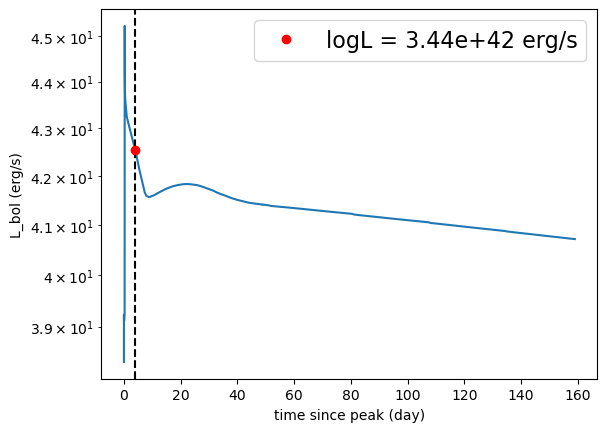

In [3]:
chosen_day = "04"
stella_model = read_stella_model(f"{STELLA_model_folder}/res/mesa.day0{chosen_day}_post_Lbol_max.data")
print(stella_model.data.columns)

# get the time at shock break out 
with open(f"{STELLA_model_folder}/data_at_end.data") as file:
    # Read first 2 lines and replace " (" with "("
    first_two_lines = []
    for i in range(2):
        line = file.readline()
        first_two_lines.append(line.replace(" (", "(").replace("D","e").split())

SBO_data = pd.DataFrame(first_two_lines[1:],columns = first_two_lines[0])
SBO_time_in_day = float(SBO_data["age(days)"][0])
print("SBO_time_in_day",SBO_time_in_day)

# plot the bolometric LC and get the time relative to SBO and bolometeric luminosity 
df_lbol = pd.read_csv(f"{STELLA_model_folder}/res/mesa.lbol",delim_whitespace=True)
plt.plot(df_lbol.time, df_lbol.L_bol)
plt.axvline(x=float(chosen_day), color='k', linestyle='--')
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("time since peak (day)")
plt.ylabel("L_bol (erg/s)")

t_exp_in_day = float(chosen_day) + np.abs(df_lbol.time.min()) + SBO_time_in_day
index_at_chosen_day = np.argmin(np.abs(df_lbol.time-float(chosen_day)))
time_diff = np.abs(df_lbol.time[index_at_chosen_day]-float(chosen_day))
if time_diff>0.5:
    print(f"Warning: The close day is {df_lbol.time[index_at_chosen_day]} and has a time difference of {time_diff} days comparing to the chosen day {chosen_day}")
L_bol_at_chosen_day = np.power(10, df_lbol.L_bol.values[index_at_chosen_day])
print("t_exp_in_day",t_exp_in_day)
print("L_bol_at_chosen_day",L_bol_at_chosen_day)

plt.plot(float(chosen_day),np.log10(L_bol_at_chosen_day),"ro",label=f"logL = {L_bol_at_chosen_day:.2e} erg/s")
plt.legend(fontsize=16)


# Check composition isotopes 

Profile has 20 isotopes and stella model has 21
na23 is in profile but not in stella model


,he3,ti44,cr48,cr60,fe52,fe54,fe56,co56
0,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000947,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000947,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000947,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000947,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000947,0.0
...,...,...,...,...,...,...,...,...
396,0.0,0.0,0.0,0.0,0.0,0.0,0.000126,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.000126,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.000126,0.0


,he3,ti44,cr48,cr60,fe52,fe54,fe56,co56
0,2.449277e-07,0.000003,0.000004,4.111583e-14,0.000041,0.000085,0.001020,5.950008e-10
1,2.449277e-07,0.000003,0.000004,4.111583e-14,0.000041,0.000085,0.001020,5.950008e-10
2,2.449277e-07,0.000003,0.000004,4.111583e-14,0.000041,0.000085,0.001020,5.950008e-10
3,2.449277e-07,0.000003,0.000004,4.111583e-14,0.000041,0.000085,0.001020,5.950008e-10
4,2.449277e-07,0.000003,0.000004,4.111583e-14,0.000041,0.000085,0.001020,5.950008e-10
...,...,...,...,...,...,...,...,...
1162,2.676528e-22,0.000034,0.000059,5.741461e-13,0.000567,0.000379,0.000989,9.254506e-10
1163,2.676528e-22,0.000034,0.000059,5.741461e-13,0.000567,0.000379,0.000989,9.254506e-10
1164,2.676528e-22,0.000034,0.000059,5.741461e-13,0.000567,0.000379,0.000989,9.254506e-10
1165,2.676528e-22,0.000034,0.000059,5.741461e-13,0.000567,0.000379,0.000989,9.254506e-10


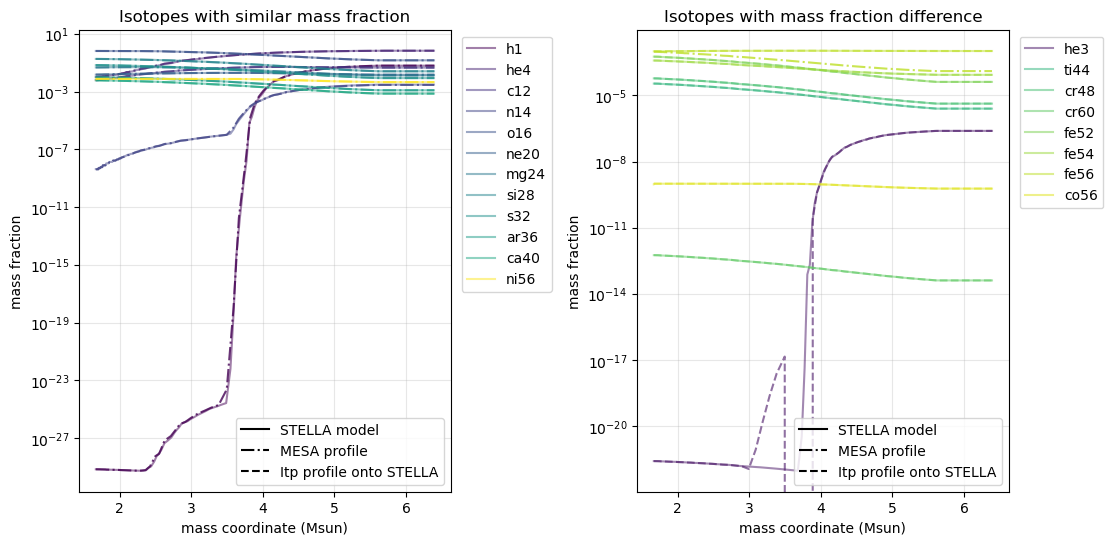

In [10]:
df_profile = pd.read_csv(f"{STELLA_model_folder}/profile1.data",sep=r'\s+',skiprows=5)
composition_columns_profile = [col for col in df_profile.columns if col[0].isalpha() and col[-1].isdigit() and "_" not in col and col not in ["gamma1","pnhe4"]]

if tau_upper_limit is not False:
    df_model_stella = stella_model.data[stella_model.data["tau"]<=tau_upper_limit]
else:
    df_model_stella = stella_model.data.copy()

composition_columns_stella = [col for col in df_model_stella.columns if col[0].isalpha() and col[-1].isdigit()]
print(f"Profile has {len(composition_columns_profile)} isotopes and stella model has {len(composition_columns_stella)}")

color_set = cm.viridis(np.linspace(0, 1, len(composition_columns_stella)))

trouble_isotopes = []
trouble_isotopes_itp_mass_fractions = []

fig,axes = plt.subplots(1,2,figsize=(12,6))
plt.subplots_adjust(wspace=0.5)
for i, isotope in enumerate(composition_columns_stella):
    if isotope not in composition_columns_profile:
        print(f"{isotope} is in profile but not in stella model")
    else:
        # compare the mean mass fractions
        center_mass = ((df_profile["mass"].values[:-1]+df_profile["mass"].values[1:])/2).astype(np.float64)[::-1]
        center_mass_fraction =( (df_profile[isotope].values[:-1]+df_profile[isotope].values[1:])/2).astype(np.float64)[::-1]
        mass_fraction_ratio_tor = 0.5
        mass_fraction_ratio = np.abs(df_model_stella[isotope].mean()/np.mean(center_mass_fraction))
        if mass_fraction_ratio >= mass_fraction_ratio_tor and mass_fraction_ratio_tor <= 1/mass_fraction_ratio_tor:
            ax = axes[0] # plot the ones without large difference
        else:
            ax = axes[1] # plot the ones with large differences 
            trouble_isotopes.append(isotope)
            # interpolate the mass fraction to match the ones in profile 
            if INTERPOLATE_MASS_FRACTIONS:
                stella_mass_fraction = df_model_stella[isotope]
                stella_mass_corrdinates = (df_model_stella["cell_center_m"]/(u.Msun.to(u.g))).astype(np.float64)
                f_itp = interpolate.interp1d(center_mass, center_mass_fraction,kind="cubic",bounds_error=False, fill_value=(center_mass_fraction[0],center_mass_fraction[-1]))
                trouble_isotopes_itp_mass_fraction = f_itp(stella_mass_corrdinates)
                trouble_isotopes_itp_mass_fractions.append(trouble_isotopes_itp_mass_fraction)
                axes[1].plot(df_model_stella["cell_center_m"]*u.g.to(u.Msun),trouble_isotopes_itp_mass_fraction,alpha=0.6,ls="--",color = color_set[i])
        # plot the stella model composition
        ax.plot(df_model_stella["cell_center_m"]*u.g.to(u.Msun),df_model_stella[isotope],alpha=0.8,ls="-.",color = color_set[i])
        # plot the profile composition
        ax.plot(center_mass,center_mass_fraction,alpha=0.5,color = color_set[i],label=isotope)
for ax in axes:
    ax.set_xlabel("mass coordinate (Msun)")
    ax.set_ylabel("mass fraction")
    ax.set_yscale("log")
    # ax.set_ylim(1e-13,1)
    # add a extra legend 
    ax.plot([],[],"k-",label="STELLA model")
    ax.plot([],[],"k-.",label="MESA profile")
    ax.plot([],[],"k--",label="Itp profile onto STELLA")
    handles, labels = ax.get_legend_handles_labels()
    leg1 = ax.legend(handles[:-3], labels[:-3],fontsize=10,bbox_to_anchor=(1.01,1))
    leg2 = ax.legend(handles[-3:], labels[-3:],fontsize=10)
    fig.add_artist(leg1)
    ax.grid(alpha=0.3)
axes[0].set_title("Isotopes with similar mass fraction")
axes[1].set_title("Isotopes with mass fraction difference")

display(df_model_stella[trouble_isotopes],df_profile[trouble_isotopes])

Question spotted: 
- Na is not in MESA profile but in STELLA model?
- Some isotopes are include in STELLA as a column, but either got zeroed out or a constant value that is slightly different from the MESA profiles, see the subplot above on the right hand side 

In [11]:
### filter and compute the key information  
matter_columns = ["cell_center_v","avg_density","radiation_temperature"]
composition_columns_stella = [col for col in df_model_stella.columns if col[0].isalpha() and col[-1].isdigit()]
df_model = df_model_stella[matter_columns+composition_columns_stella]

# update the column names 
df_model = df_model.rename(columns = {"cell_center_v":"velocity","avg_density":"density","radiation_temperature":"t_rad"})
df_model = df_model.rename(columns = {col:col[0].capitalize()+col[1:] for col in composition_columns_stella})

# filter out the columns that are not needed, eg all zero
df_model = df_model.astype(np.float128)
df_model = df_model.loc[:,(df_model!=0).all()]
df_model

,velocity,density,t_rad,H1,He4,C12,N14,O16,Ne20,Na23,Mg24,Si28,S32,Ar36,Ca40,Fe56,Ni56
0,,,,,,,,,,,,,,,,,
1,5.620234e+06,1.314823e-05,1.232338e+06,7.086659e-30,0.010378,0.006202,4.117733e-09,0.646870,0.014980,1.919466e-10,0.046939,0.182153,0.068068,0.009800,0.006010,0.000947,0.007560
2,1.520838e+07,1.712011e-10,3.455998e+04,7.086659e-30,0.010378,0.006202,4.117733e-09,0.646870,0.014980,1.919466e-10,0.046939,0.182153,0.068068,0.009800,0.006010,0.000947,0.007560
3,2.147208e+07,7.666949e-11,3.361370e+04,7.086659e-30,0.010378,0.006202,4.117733e-09,0.646870,0.014980,1.919466e-10,0.046939,0.182153,0.068068,0.009800,0.006010,0.000947,0.007560
4,2.561156e+07,6.909861e-11,3.345926e+04,7.086659e-30,0.010378,0.006202,4.117733e-09,0.646870,0.014980,1.919466e-10,0.046939,0.182153,0.068068,0.009800,0.006010,0.000947,0.007560
5,2.887946e+07,6.598866e-11,3.340050e+04,7.086659e-30,0.010378,0.006202,4.117733e-09,0.646870,0.014980,1.919466e-10,0.046939,0.182153,0.068068,0.009800,0.006010,0.000947,0.007560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,1.915926e+09,5.460173e-15,7.861992e+03,6.227028e-02,0.674126,0.045512,2.892982e-03,0.146375,0.014682,1.348553e-04,0.013084,0.025450,0.008617,0.001233,0.000725,0.000126,0.004534
397,1.962913e+09,4.847349e-15,7.598724e+03,6.227028e-02,0.674126,0.045512,2.892982e-03,0.146375,0.014682,1.348553e-04,0.013084,0.025450,0.008617,0.001233,0.000725,0.000126,0.004534
398,2.023322e+09,4.603179e-15,7.334445e+03,6.227028e-02,0.674126,0.045512,2.892982e-03,0.146375,0.014682,1.348553e-04,0.013084,0.025450,0.008617,0.001233,0.000725,0.000126,0.004534


# Convert to tardis configs

## cvsy model file

In [16]:
# write the csvy file for composition, density and radiative temperature
tardis_sample_csvy_path = "TARDIS_example_configs/tardis_example_csvy.csvy"

def write_tardis_csvy(modify_csvy_headers, df_csv, new_csvy_path):
    """
    Purpose:
    ---------
    Write the TARDIS model csvy file for a specific time step.

    ----------
    Parameters:
        modify_csvy_headers: dict
            The dictionary that contains the to-be modified headers
        new_csvy_path: str
            The path to the new csvy file
    """
    # Read the sample csvy file
    with open(tardis_sample_csvy_path, "r") as file:
        csvy_lines = file.readlines()

    # Find the lines between "---" and datatype -- these are the headers
    start_index = csvy_lines.index("---\n")
    end_index = csvy_lines.index("datatype:\n")

    # Parse the lines as YAML
    yml_lines = csvy_lines[start_index:end_index]
    yml_data = yaml.safe_load("".join(yml_lines))

    # Modify the header dictionary as needed
    for key, value in modify_csvy_headers.items():
        yml_data[key] = value

    # add the datatype fields
    fields = get_fields_names(df_csv.columns.to_list())
    yml_data["datatype"] = {"fields": fields}

    # Convert the yml data back to lines
    yml_lines = yaml.dump(yml_data, sort_keys=False).splitlines()
    yml_lines = [line + "\n" for line in yml_lines]

    # Convert the csv data to lines
    csv_lines = df_csv.to_csv(index=False, float_format="%.5e", sep=",").splitlines()
    csv_lines = [line + "\n" for line in csv_lines]

    # Save the updated csvy data
    updated_csvy_lines = (
        csvy_lines[: start_index + 1] + yml_lines + ["---\n"] + csv_lines
    )
    with open(new_csvy_path, "w") as file:
        file.writelines(updated_csvy_lines)


def get_fields_names(column_names):
    fields = [
        {
            "name": "velocity",
            "unit": "cm/s",
            "desc": "velocities of shell outer bounderies.",
        },
        {
            "name": "density",
            "unit": "g/cm^3",
            "desc": "density within shell with corresponding outer velocity.",
        },
    ]

    if ("velocity" not in column_names) or ("density" not in column_names):
        ValueError("velocity and density are required fields.")
    else:
        column_names.remove("velocity")
        column_names.remove("density")

    if "t_rad" in column_names:
        fields.append(
            {
                "name": "t_rad",
                "unit": "K",
                "desc": "radiative temperature within shell with corresponding outer velocity.",
            }
        )
        column_names.remove("t_rad")

    if "dilution_factor" in column_names:
        fields.append(
            {
                "name": "dilution_factor",
                "desc": "dilution factor within shell with corresponding outer velocity.",
            }
        )
        column_names.remove("dilution_factor")

    # assume the rest are fractional abundance
    for element in column_names:
        # check the column is a valid element
        if is_valid_nuclide_or_elem(element):
            fields.append(
                {
                    "name": element,
                    "desc": f"fractional {element} abundance",
                }
            )
        else:
            Warning(f"{element} is not valid nuiclide in tardis database.")

    return fields


# write the tardis csvy file
new_csvy_path = (
    f'{STELLA_model_folder}/tardis_configs/Day_{chosen_day}_mesa_stella_model.csvy'
)
modify_csvy_headers = {
    "name": "mesa_stella_model.csvy",
    "model_density_time_0": f"{t_exp_in_day:.4f} day",
    "model_isotope_time_0": f"{SBO_time_in_day:.4f} day",
    "description": "sample mesa stella model converted to csvy format for tardis simulation",
    "v_inner_boundary": f"{df_model["velocity"].min():.5e} cm/s",
}
write_tardis_csvy(modify_csvy_headers, df_model, new_csvy_path)

## Write the tardis config yml

In [19]:
tardis_sample_config_path = "TARDIS_example_configs/tardis_example_config_SESN.yml"


def write_tardis_config(modify_parameters, new_config_path, csvy_model_path=None):
    """
    Purpose:
    ---------
    Write the TARDIS config file for a specific time step.

    ----------
    Parameters:
        modified_parameters: dict
            The dictionary that contains the to-be modified parameters
        new_config_path: str
            The path to the new config file
    """
    # load in the sample config yml
    with open(tardis_sample_config_path, "r") as file:
        config = yaml.safe_load(file)

    # Modify the config dictionary as needed
    for key1, params in modify_parameters.items():
        for key2, value in params.items():
            config[key1][key2] = value

    if csvy_model_path is not None:
        config["csvy_model"] = csvy_model_path

    # Save the modified config back to a new YAML file
    with open(new_config_path, "w") as file:
        yaml.safe_dump(config, file, sort_keys=False)


# write the tardis config file
# rough;y estimate the photosphere index using tau = 2/3
ph_idx = stella_model.data.index[stella_model.data["tau"].sub(2/3).abs().idxmin()]

modify_parameters = {
    "supernova": {
        "luminosity_requested": f"{L_bol_at_chosen_day} erg/s",
        "time_explosion": f"{t_exp_in_day:.4f} day",
    },
    "plasma": {
        "initial_t_inner": f"{df_model.loc[ph_idx, 't_rad']} K"
    },
}
new_config_path = f'{STELLA_model_folder}/tardis_configs/Day_{chosen_day}_mesa_stella_tardis.yml'
write_tardis_config(
    modify_parameters,
    new_config_path,
    csvy_model_path=f"Day_{chosen_day}_mesa_stella_model.csvy",
)